<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/notebooks/eumun_to_eumjul_network_bidirectional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
import copy
import matplotlib.pyplot as plt
import random

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
data_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/eumjul_eumun_pairs.npy'

pairs = np.load(data_path)

In [0]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
# unicode_jamo_list += [' ', '!', ',', '.', '?', '<eos>']
    
unicode_jamo_list.sort()

# unicode_jamo_list = ['-'] + unicode_jamo_list

print(unicode_jamo_list)
print(len(unicode_jamo_list))

[' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
74


In [0]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

tokenized_pair = [[tokenizer.word2num(list(pairs[i, 0]) + ['<eos>']), tokenizer.word2num(list(pairs[i, 1]) + ['<eos>'])] for i in range(len(pairs))]

In [0]:
idxs = range(0, len(tokenized_pair))

train_size = int(0.8 * len(tokenized_pair))

train_idxs = set(np.random.choice(idxs, train_size, False))

total_idxs_set = set(idxs)

eval_idxs = list(total_idxs_set - train_idxs)

train_idxs = list(train_idxs)

train_pairs = [tokenized_pair[idx] for idx in train_idxs]
eval_pairs = [tokenized_pair[idx] for idx in eval_idxs]

print("Size of the total pairs: {}".format(len(tokenized_pair)))
print("Size of the training pairs: {}".format(len(train_pairs)))
print("Size of the evaluation pairs: {}".format(len(eval_pairs)))

Size of the total pairs: 51955
Size of the training pairs: 41564
Size of the evaluation pairs: 10391


In [0]:
def ordered_shuffling(pairs, shuffle_step = 12):
    eumun_length_list = np.asarray([len(pair[1]) for pair in pairs])
    
#   print(eumun_length_list)
    
    sorted_order = np.argsort(eumun_length_list)
    
    bundle = np.stack([eumun_length_list[sorted_order], sorted_order])

    for seq_len in range(shuffle_step, np.max(eumun_length_list), shuffle_step):
        idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + shuffle_step))[0]
        idxs_origin = copy.deepcopy(idxs)
        random.shuffle(idxs)
        bundle[:, idxs_origin] = bundle[:, idxs]

    shuffled_sorted_order = bundle[1, :]
    
#     plt.figure()
#     plt.plot(eumun_length_list[shuffled_sorted_order])
#     plt.show()
    
    return [pairs[order] for order in shuffled_sorted_order]

In [0]:
len(ordered_shuffling(train_pairs))

41564

In [0]:
class Batch_Loader():
    def __init__(self, sentence_pairs, shuffle_step = 12, batch_size = 1000):
        super(Batch_Loader).__init__()
        self.sentence_pairs = sentence_pairs
        self.total_num_input = len(sentence_pairs)
        self.shuffle_step = shuffle_step
        self.end_flag = True
        self.batch_size = batch_size
        self.current_loading_index = 0
    
    def initialize_batch(self):
        self.sentence_pairs = ordered_shuffling(self.sentence_pairs)
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        eumjul_list = list()
        eumun_list = list()
        eumjul_length_list = list()
        eumun_length_list = list()

        count = 0
        max_eumjul_len = 0
        max_eumun_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            pair = self.sentence_pairs[self.current_loading_index]
            eumjul = pair[0]
            eumun = pair[1]
            
            eumjul_list.append(eumjul)
            eumun_list.append(eumun)
            
            eumjul_length_list.append(len(eumjul))
            eumun_length_list.append(len(eumun))
            
            if (len(eumjul) > max_eumjul_len):
                max_eumjul_len = len(eumjul)
            if (len(eumun) > max_eumun_len):
                max_eumun_len = len(eumun)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_eumjul = torch.zeros(count, max_eumjul_len)
        batched_eumun = torch.zeros(count, max_eumun_len)
        batched_loss_mask = torch.zeros(count, max_eumjul_len)
        
#         print(eumjul_list)
        
        for order in range(count):
        
            batched_eumjul[order, :eumjul_length_list[order]] = torch.tensor(eumjul_list[order])
            batched_eumun[order, :eumun_length_list[order]] = torch.tensor(eumun_list[order])
            batched_loss_mask[order, :eumjul_length_list[order]] = torch.ones(eumjul_length_list[order])
        
        return batched_eumjul, batched_eumun, batched_loss_mask

In [0]:
# eumjul_batch, eumun_batch, eumun_loss_mask = train_batch_loader.get_batch()

In [0]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
############################################################################

class EncoderRNN(nn.Module):
    def __init__(self, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
#         self.gru = nn.GRU(hidden_size, hidden_size)
        self.gru = nn.GRU(hidden_size, int(hidden_size/2), bidirectional=True)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        
        return output, hidden

    def initHidden(self, batch_size):
#         return torch.zeros(1, batch_size, self.hidden_size, device=device)
          return torch.zeros(2, batch_size, int(self.hidden_size/2), device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=10):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, len(jamo_tokens))

    def forward(self, embedded, hidden, encoder_outputs):

        embedded = self.dropout(embedded)
        
#         print(embedded.shape)
#         print(hidden.shape)
        
        #(1, B, H) + (1, B, H) = (1, B, 2H)        
        concated_tensor = torch.cat((embedded, hidden), 2)
        
        # (1, B, H)
        key = self.attn(concated_tensor)
        
        # (B, H, 1)
        key = key.permute(1, 2, 0)
        
        # (B, L, 1)        
        attention_value = torch.bmm(encoder_outputs, key)
        
        attn_weights = F.softmax(attention_value, dim=1)
        
        # (B, 1, L)
        attn_weights = attn_weights.permute(0, 2, 1)
        
        # (B, 1, H)
        attn_applied = torch.bmm(attn_weights, encoder_outputs)

        # (1, B, H)
        attn_applied = attn_applied.permute(1, 0, 2)
        
        # (1, B, 2H)
        output = torch.cat((embedded, attn_applied), 2)
        
        # (1, B, H)
        output = self.attn_combine(output)

        output = F.relu(output)
        
        # (1, B, H)
        output, hidden = self.gru(output, hidden)

        # (1, B, 74)
        output = F.log_softmax(self.out(output), dim=2)
        return output.squeeze(0), hidden, attn_weights.squeeze(1)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
class Seq2SeqNet():
    def __init__(self, hidden_size):
        super(Seq2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.device = device
        
        self.hidden_size = hidden_size
        
        self.embedding_layer = nn.Embedding(len(jamo_tokens), hidden_size).to(device) 
        self.embedding_layer_2 = nn.Embedding(len(jamo_tokens), hidden_size).to(device)
        self.encoder = EncoderRNN(hidden_size).to(device)
        self.decoder = AttnDecoderRNN(hidden_size,len(jamo_tokens), dropout_p=0.1).to(device)
        
        self.embedding_optimizer = optim.SGD(self.embedding_layer.parameters(), lr=0.001)  
        self.embedding_optimizer_2 = optim.SGD(self.embedding_layer_2.parameters(), lr=0.001)  
        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)

#         self.criterion = nn.CrossEntropyLoss(reduction='none').to(device)
        self.criterion = nn.NLLLoss(reduction='none').to(device)
#         self.ctc_loss = nn.CTCLoss().to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer_2.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def train(self, input_tensor, target_tensor, loss_mask):
        
        self.embedding_optimizer.zero_grad()
        self.embedding_optimizer_2.zero_grad()
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]
        
#       input_tensor = torch.cuda.LongTensor(input_tensor.long().to(device))
        input_tensor = torch.cuda.LongTensor(input_tensor.long())
        target_tensor = torch.cuda.LongTensor(target_tensor.long())
        
        embedded_tensor = self.embedding_layer(input_tensor)
        
        embedded_tensor = embedded_tensor.permute(1, 0, 2)
        
        # (L, B)
        target_tensor = target_tensor.permute(1, 0)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        loss = 0

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output
            
        decoder_input_token = torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).long().unsqueeze(0).to(device)

        
        # Override encoder hidden state
        encoder_hidden = encoder_outputs[-1, :, :].unsqueeze(0)
        
        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # Override encoder_hidden
        
        decoder_hidden = encoder_hidden
        
        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(jamo_tokens)])

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)
            
#             print('Decoder Input Shape: {}'.format(decoder_input.shape))
            
            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += torch.mean(self.criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])
                        
            decoder_input_token = target_tensor[di].unsqueeze(0)
            
            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output
            
#       print(decoder_output.shape)

        loss.backward()

        self.embedding_optimizer.step()
        self.embedding_optimizer_2.step()
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return decoder_outputs, decoder_attentions, loss.item() / target_length
    
    

    def evaluate(self, input_tensor, target_tensor, loss_mask):
        
        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]
        
        input_tensor = torch.cuda.LongTensor(input_tensor.long())
        target_tensor = torch.cuda.LongTensor(target_tensor.long())
        
        embedded_tensor = self.embedding_layer(input_tensor)
        embedded_tensor = embedded_tensor.permute(1, 0, 2)
        
        # (L, B)
        target_tensor = target_tensor.permute(1, 0)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        loss = 0

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output
            
        decoder_input_token = torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).long().unsqueeze(0).to(device)

        # Override encoder hidden state
        encoder_hidden = encoder_outputs[-1, :, :].unsqueeze(0)
        
        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        decoder_hidden = encoder_hidden
        
        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(jamo_tokens)])

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)

            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += torch.mean(self.criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])
                        
            decoder_input_token = target_tensor[di].unsqueeze(0)
            
            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output


        return decoder_outputs, decoder_attentions, loss.item() / target_length
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'embedding_layer_2_state_dict': self.embedding_layer_2.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'embedding_optimizer_2_state_dict': self.embedding_optimizer_2.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.embedding_layer_2.load_state_dict(checkpoint['embedding_layer_2_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.embedding_optimizer_2.load_state_dict(checkpoint['embedding_optimizer_2_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
        
    def set_mode(self, mode):
        
        if mode == 'train':
            self.embedding_layer.train()
            self.embedding_layer_2.train()
            self.encoder.train()
            self.decoder.train()
            
        elif mode == 'eval':
            self.embedding_layer.eval()
            self.embedding_layer_2.eval()
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
net = Seq2SeqNet(256)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
train_batch_loader = Batch_Loader(train_pairs, 12, 1024)
train_batch_loader.initialize_batch()

eval_batch_loader = Batch_Loader(eval_pairs, 12, 1024)
eval_batch_loader.initialize_batch()

Loading Failed
Loading Error
09-13 02:29:52
09-13 02:30:25
Mean Train Loss: 2.686044284261893
09-13 02:30:28
Mean Evaluation Loss: 2.0267103872117844


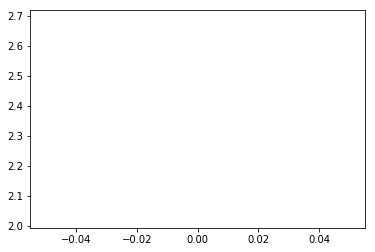

수직 쩡워니란 싱물과 공기청정기 기능을 결하판 거스로 실래에 오염된 공기를 이페서 토양 그리고 뿌리 미생물로 순환시키는 녀카를 한다.<eos>                                                                                                                                       
안ᅡᆫᄋ아 은 ᅳᆫᅳᆫ 안아  ᅡᆫ아 아 ᅡ 아 아 아 ᅳᆫ ᅳᆫ 안 ᅡᆫ아  아 은ᅳ 아  ᅡ ᅳ 아 ᅵᆫ아  아 아 ᅡᆫ 이 이 ᅡ 아 ᅳ ᄋᄋ안ᅡ ᅡ 아 ᅡ 아 ᅡ 아  ᅡ 아  ᅡᆫ ᅡ ᄋ ᅡᆫ 인안 ᅵᆫ 안 ᅡ <eos> ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
수직 정원이란 식물과 공기청정기 기능을 결합한 것으로 실내의 오염된 공기를 잎에서 토양, 그리고 뿌리 미생물로 순환시키는 역할을 한다.<eos>                                                                                                                                       
비록 일쩨에 무자비한 타나브로 성공하지는 모타여쓰나 민족싸저그로 우리이 동니 븨사를 궁ᄂ

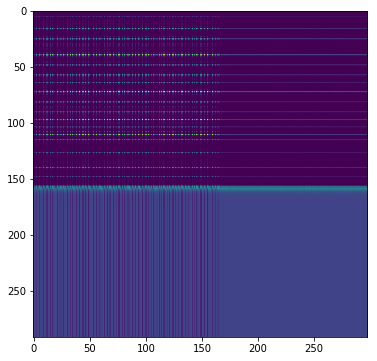

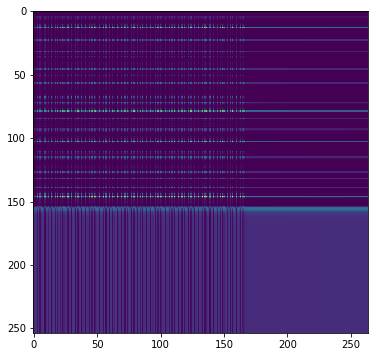

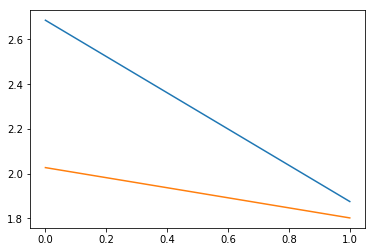

공간정보를 외주용역 하고자 할 때에는 미리 보안채김자를 지정하여 용여겁체에 대한 보안괄리 실태를 파아칸 후 대채글 마련하여야 한다.<eos>                                                                                                                                          
아 앙 ᅵᆼ앙ᅳᆫ 긴ᅵᆫᅳ. ᅳᆫ 간ᅡ ᅵᆼ안 가이 ᅳᆫ 간ᅡᆫ앙ᅵᆫ ᅵ 으 잉ᅳᆫ 군ᅮᆼ안ᅭᆫ이.은 ᅳ 이 ᅭ 아안 강ᅭᆫ ᅡ  ᅡ 아ᄋ아안 앙ᅭᆫ ᅡᆫ 가ᄋ아아 을 강ᅡᆫ ᅡᆫᅭ ᅭ.앙 ᅡᆼ<eos><eos>ᄒᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀ
공간정보를 외주용역 하고자 할 때에는 미리 보안책임자를 지정하여 용역업체에 대한 보안관리 실태를 파악한 후 대책을 마련하여야 한다.<eos>                                                                                                                                             
무인미눤발급끼 믿 주민등녹꽐리시스테므로 발그파는 모든 증명에는 다음 각 호에 

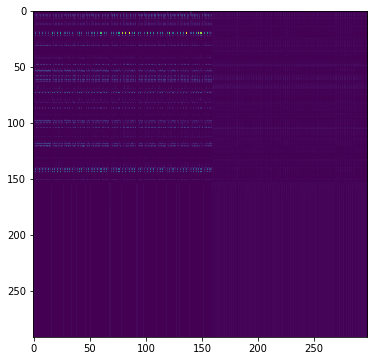

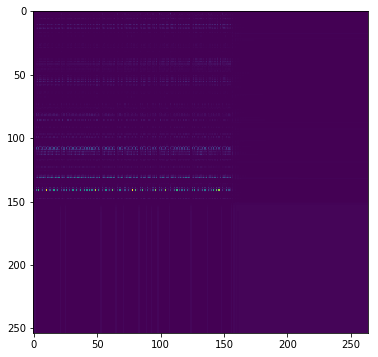

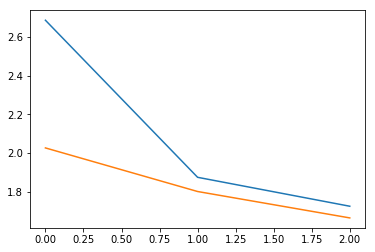

서산 지여근 어촌 농촌 산촌 등 다양한 지역쩍 특썽을 보이고 이쓰며 이러한 생활 모스블 바녕한 노리 문화도 고루 발달하엳따.<eos>                                                                                                                                                  
강ᅥᆼ 군ᅳᆫ은 긴ᅥᆼ  강앙  강앙 간ᄋ강ᅳ 안 군ᅳᆫ잉ᄋ갈앙을 강ᅵᆫᅡ 인은ᅧᆫ 긴ᅥᆼᅡᆫ 강안 궁ᅵᆫ을 강인한 강으 안안ᅡ 앙ᅡᆫ앙앙 ᅡᆫᅭ 아ᄋ<eos><eos>ᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄋᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀ
서산 지역은 어촌, 농촌, 산촌 등 다양한 지역적 특성을 보이고 있으며, 이러한 생활 모습을 반영한 놀이 문화도 고루 발달하였다.<eos>                                                                                                                                                 
비록 일쩨에 무자비한 타나브로 성공하지는 모타여쓰나 민족싸저그로 우리이 동니 븨사를 

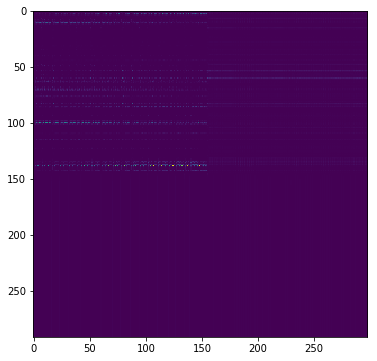

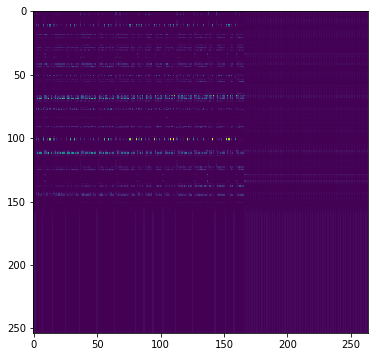

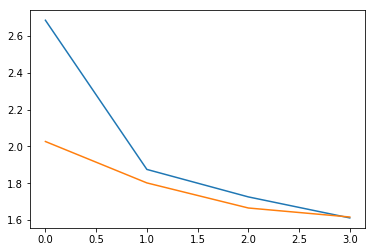

신부 쪼게는 소늘 씯꼬 다끌 쑤 읻또록 무리 담긴 대야와 술주전자를 두고 실랑 쪼게는 특뼐히 지베서 만든 두부와 저까라글 놔둔다.<eos>                                                                                                                                                 
간군앙이 ᅳᆫ 강인 가ᄀ아 앙을 가ᄋ인앙ᅳ  군인앙아 ᄋ강ᅭᆼᅭ 안욱ᅥᆼ ᅡᆼᅳᆯ 가 ᅡᆼ 갈안ᄒ강이 ᅡᆫ 갈웅안울이아 알달 가룬ᅭᆻ앙앙ᅡᆯ ᅳᆯ 가아 앙<eos><eos>ᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄋᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄋᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄋᄀᄀᄋᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄋᄀᄋᄀᄀᄀᄀᄀᄀᄋᄀᄋᄀᄀᄋᄀᄀᄀᄀᄋᄀ
신부 쪽에는 손을 씻고 닦을 수 있도록 물이 담긴 대야와 술주전자를 두고, 신랑 쪽에는 특별히 집에서 만든 두부와 젓가락을 놔둔다.<eos>                                                                                                                                               
제과는 깨끄탄 사람 즉 흉사가 엄는 사람 임산부가 엄는 지반 아픈 사라미 엄는 지ᄇ

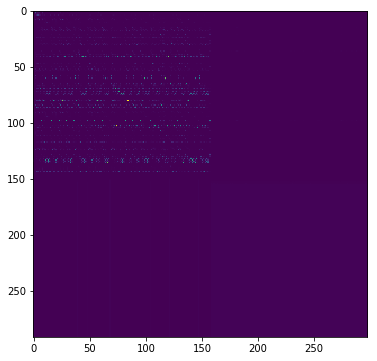

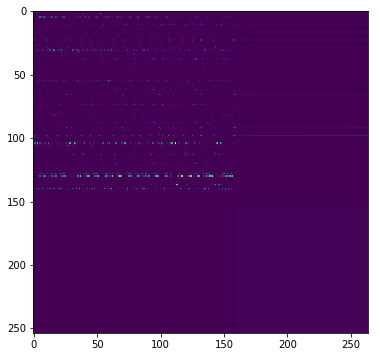

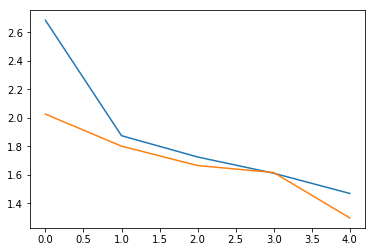

이름 대기 노리는 주로 아이드리 모여서 한 사라미 글짜 하나를 말하면 그 글짜로 끈나는 다너를 생가캐 내어 말하는 모이재현형 민송노리이다.<eos>                                                                                                                                          
이른ᄋ앙ᅡ 아ᄋ이은 우옹이인ᅳᆫ ᅵ 아잉ᅡᆼ안ᄃ강ᅡᆼ이 으ᄅ랑안ᅡᆫᅩᆯ 간 ᅡ년 그ᄅ으ᄅ ᅡᆼᅩ 알아는 긍안ᅳᆯ 가ᄋ악았자인안라는 가이 ᅡᆼᅡᆫ ᅡᆫᄒ가ᄋ앙하  ᅵ ᅦ ᅡ.<eos><eos>ᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀ
이름 대기 놀이는 주로 아이들이 모여서 한 사람이 글자 하나를 말하면 그 글자로 끝나는 단어를 생각해 내어 말하는 모의재현형 민속놀이이다.<eos>                                                                                                                                           
쌍용자동차도 수출 감소로 전체저긴 판매 물량이 주럳꼬 부정저긴 화뉼과 판매비용 

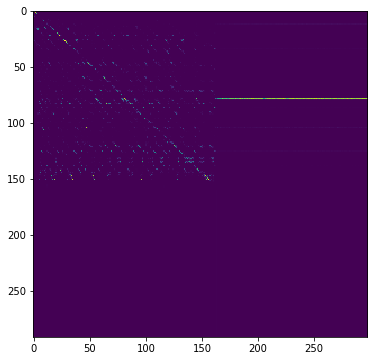

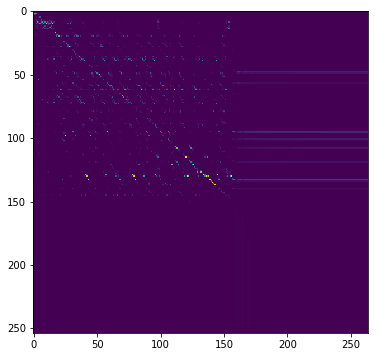

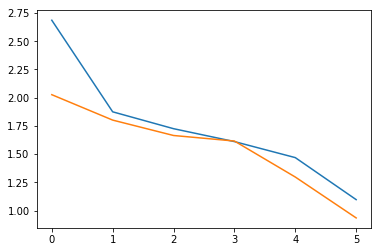

구는 환경오여메 워니니 되는 행위 믿 자연환경에 적쩡한 보저네 지장을 미치 루려가 인는 행위 등에 대하여 피료한 규제조치를 할 쑤 읻따.<eos>                                                                                                                                         
군ᅳᆫ 간경오의 에 연기ᄂ이 안ᅳᆫ 앵이ᄒ긴ᄋ아연한광에 인겅안 공ᅮᆼ ᅦ 이장을 일ᅵᄂᄋ이 ᅧ가 있닌 갱에ᄒ응에 응ᅡ연히ᄃ여간 고제 ᅩ ᅵᆯᅳᆯ 갤 구ᄅ있아.<eos><eos>ᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄋᄀᄀᄋᄀᄀᄀᄀᄀᄋᄋᄋᄋᄀᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
구는 환경오염의 원인이 되는 행위 및 자연환경의 적정한 보전에 지장을 미칠 우려가 있는 행위 등에 대하여 필요한 규제조치를 할 수 있다.<eos>                                                                                                                                          
이런 상황에서 정부 지워늘 통해 대기어비 중소기어블 지원할 쑤 읻께 된다면 중소기ᄋ

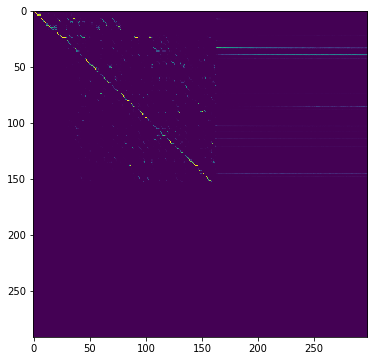

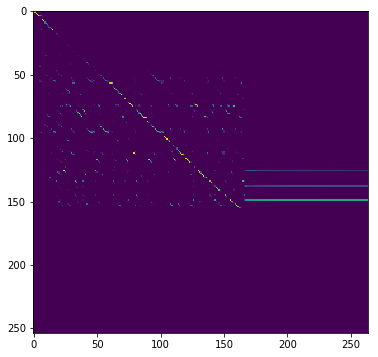

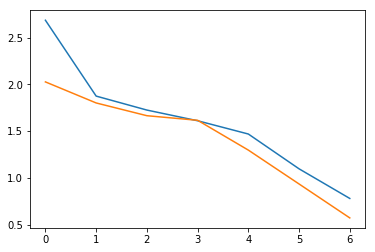

우리 정부는 리비아 정부와 공조해 무사귀화늘 위해 노려카고 이쓰며 문재인 대통녕은 청해 부대를 인근 해여그로 급파한 거스로 전해젇따.<eos>                                                                                                                                              
우리 엉분ᅳᆫ 이비아 엉분ᅳ 종조해 준ᅡ게핸은 위해 조력하고 싰으명훈재진 애 ᅩ 녕은 엉해ᄌ주대흘 인근 애여ᄀ을ᅩ 흠아한 엇으로 헌해저 다.<eos><eos>ᄃᄋᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄒᄒᄀᄀᄀᄒᄀᄀᄀᄀᄀᄒᄀᄒᄒᄒᄒᄒᄒᄀᄒᄒᄀᄀᄀᄀᄀᄀᄀᄀᄒᄒᄀᄀᄀᄀᄒᄒᄒᄀᄀᄀᄒᄒᄒᄒᄀᄀᄀᄀᄀᄀᄒᄒᄀᄀᄀᄒᄀᄀᄀᄒᄒᄒᄒᄒᄀᄀᄀᄀᄀᄒᄀᄀᄀᄀᄒᄒᄀᄒᄀᄒᄒᄒᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄒᄀᄀᄒᄒᄒᄀᄀᄀᄀᄒ
우리 정부는 리비아 정부와 공조해 무사귀환을 위해 노력하고 있으며 문재인 대통령은 청해 부대를 인근 해역으로 급파한 것으로 전해졌다.<eos>                                                                                                                                                
위원회에 청소년뉴해업쏘 믿 안저뉘해업쏘 등 유해환경에 지속쩌긴 감시 믿 계도 등ᄋ

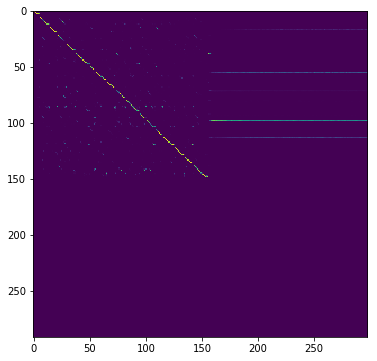

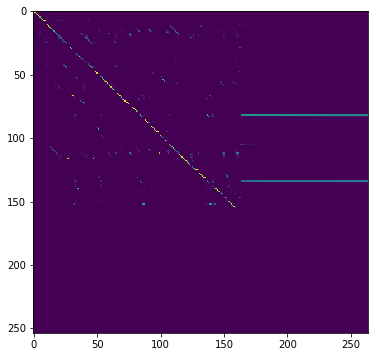

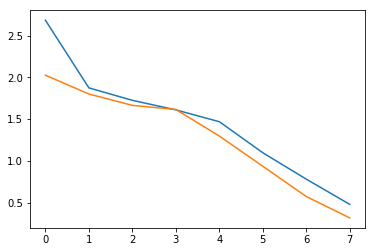

스위스과는 거꾸로 된 신바를 시는 블루칼라 남자드레 퍼포먼스 영상을 통해 거꾸로 거르므로써 저항을 연습씨켜야 한다는 메시지를 던젇따.<eos>                                                                                                                                         
스의스관은 거 ᅮ로 왼ᄃ신바ᄅ을 신은 블룩ᅡᆫ ᅡ 남자드ᄅ에 업ᅩ먼스 영상을 송해 허 ᅮ로ᄉ거ᄅ으ᄆ으로쇼 저항을 션습식ᅧ야 한다들 메시지를 던적다.<eos><eos>ᄌᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
스위스관은 거꾸로 된 신발을 신은 블루칼라 남자들의 퍼포먼스 영상을 통해 거꾸로 걸음으로써 저항을 연습시켜야 한다는 메시지를 던졌다.<eos>                                                                                                                                          
프로야구에 지를 노피기 위해선 선수마니 메이저리그를 갈 께 아니라 코치드리 미국꽈 일본 

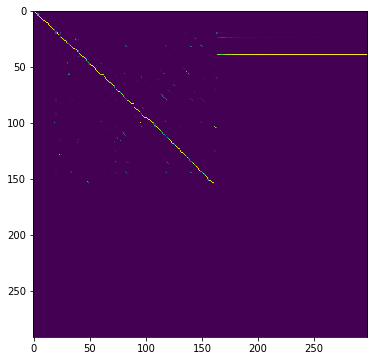

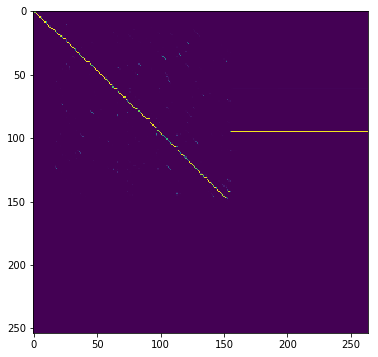

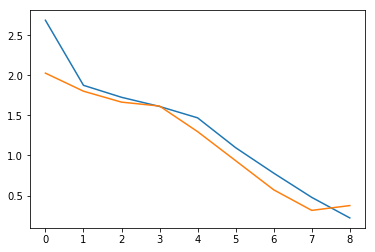

이들 마으레 정차칸 첟 쎄대는 조은 경작찌를 차자서 다른 성씨드리 살던 고스로 이주하엳꺼나 결호늘 통하여 처가가 인는 마을로 이주하엳따.<eos>                                                                                                                                        
이들 마으ᄅ에 정착한 첫 세대는 좋은 경작지를 차ᄌ아서 다른 겅시드ᄅ이 살던 고ᄉ으로 이주하였더나 결호ᄂ을 통하였척ᅡ가 있는 마을로 이주하였다.<eos><eos>ᄀᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
이들 마을에 정착한 첫 세대는 좋은 경작지를 찾아서 다른 성씨들이 살던 곳으로 이주하였거나 결혼을 통하여 처가가 있는 마을로 이주하였다.<eos>                                                                                                                                        
위워는 동장 또는 아동 괄련 단체나 기과니 다음 각 호에 어느 하나에 해당하는 사람 ᄌ

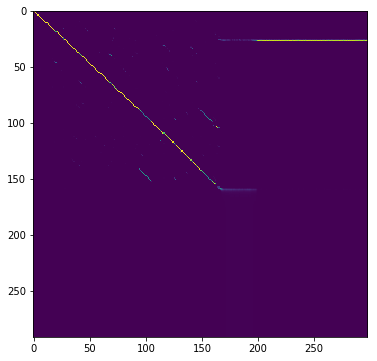

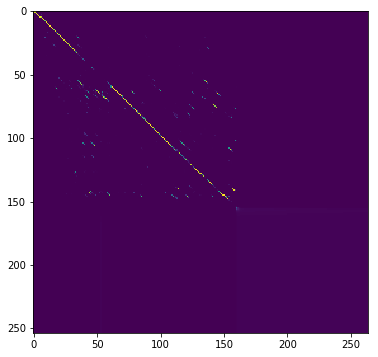

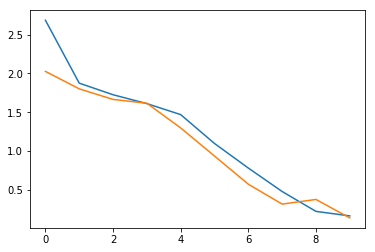

성 추무네 열루된 선수드레 조기 기용 아직또 여우니 가시지 아는 해외 카지노 추립 그리고 음주운전까지 선수드레 일탈 행위는 계속뙤고 읻따.<eos>                                                                                                                                          
성 춤ᅮᆫ에 열룬ᅬᆫ 선수들에 조기 기용  규진도 여운의 가시지 않은 해요 카지노 추ᄅ입  그리고 음주운전가지 선수들에 일탈 행위는 계속되고 였다.<eos><eos><eos><eos>ᄇᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
성 추문에 연루된 선수들의 조기 기용, 아직도 여운이 가시지 않은 해외 카지노 출입, 그리고 음주운전까지 선수들의 일탈 행위는 계속되고 있다.<eos>                                                                                                                                         
오늘랄 생활 량시기 마니 바뀐 가운데서도 조상을 숭배하는 묘사 풍스븐 변하

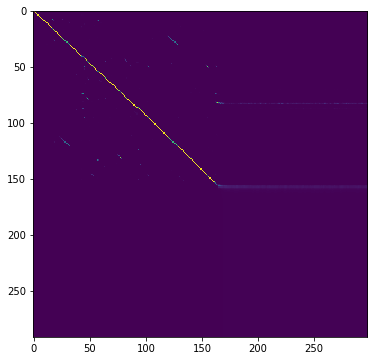

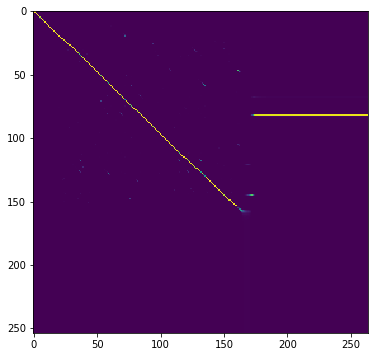

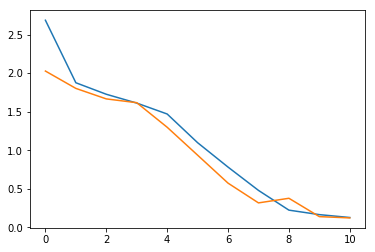

산신제를 지낼 때에는 제당 바께 제무를 진설하며 제에 방시근 간단하여 제주 한 사라미 술 한 자늘 올리고 재배하는 거스로 대신한다.<eos>                                                                                                                                               
산신제를 지낼 때에는 제당 밖에 제무ᄅ을 진설하며 제에 방식은 간단하여 제주 한 사람이 술 한 자ᄂ을 올리고 재배하는 것으로 대신한다.<eos><eos>ᄌᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
산신제를 지낼 때에는 제당 밖에 제물을 진설하며 제의 방식은 간단하여 제주 한 사람이 술 한 잔을 올리고 재배하는 것으로 대신한다.<eos>                                                                                                                                                
프로야구에 지를 노피기 위해선 선수마니 메이저리그를 갈 께 아니라 코치드리 미국꽈 일본 

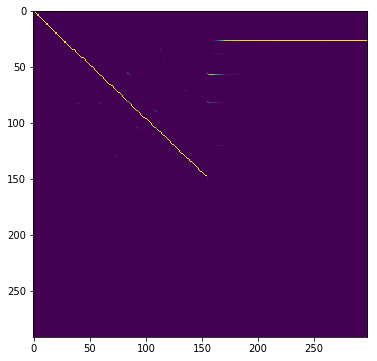

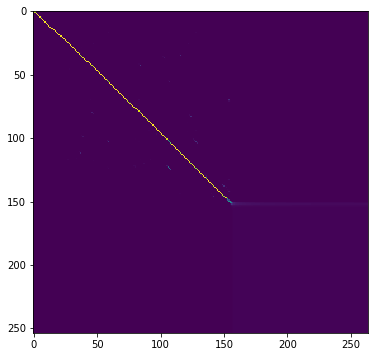

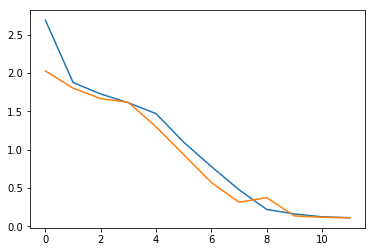

행보칸 방 만들기 사어베 차며할 깨인 단체 기업 등에 자원봉사자나 재능기부자는 구청 복찌지원과 또는 거쩜기과느로 신청하면 된다.<eos>                                                                                                                                              
행복한 방 만들기 사업에 참여할 개인  단체  기업 등에 자원봉사자나 재능기부자는 구청 복지지원과 또는 것ᅥᆷ기관으로 신청하면 된다.<eos><eos><eos>ᄌᄒᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃᄃ
행복한 방 만들기 사업에 참여할 개인, 단체, 기업 등의 자원봉사자나 재능기부자는 구청 복지지원과 또는 거점기관으로 신청하면 된다.<eos>                                                                                                                                               
위원회에 청소년뉴해업쏘 믿 안저뉘해업쏘 등 유해환경에 지속쩌긴 감시 믿 계도 

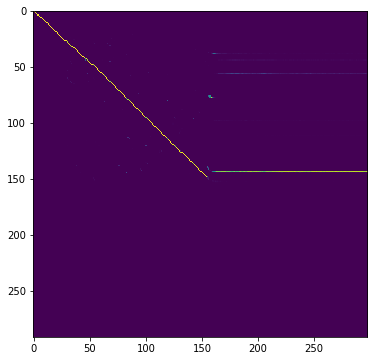

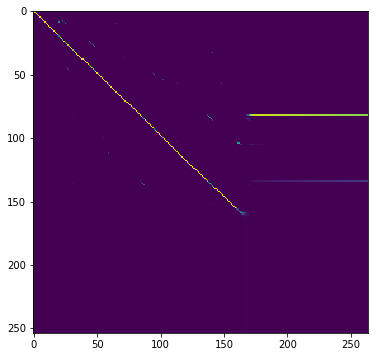

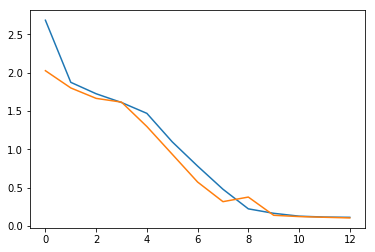

스타벅쓰는 신선하믈 유지하기 위해 충남 논산 경남 산청 등에서 수확뙨 최상급 딸기를 다음날 매장에서 맏뽈 쑤 읻또록 핻따.<eos>                                                                                                                                                
스타벅스는 신선하ᄆ을 유지하기 위해 충남 논산  경람 안청 등에서 수확된 최상급 딸기를 다음날 매장에서 샂볼 수 있도록 했다.<eos><eos><eos><eos>ᄋᄋᄋᄋᄋᄋᄋᄇᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄇᄋᄋᄋᄋᄋᄋᄉᄉᄉᄆᄉᄉᄉᄉᄆᄋᄆᄄᄄᄄᄄᄆᄋᄆᄆᄆᄄᄆᄆᄆᄆᄆᄆᄄᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄋᄆᄆᄆᄆᄆᄆᄆᄆᄆᄋᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆᄆ
스타벅스는 신선함을 유지하기 위해 충남 논산, 경남 산청 등에서 수확된 최상급 딸기를 다음날 매장에서 맛볼 수 있도록 했다.<eos>                                                                                                                                                     
숙찌게 근무시가는 정상 근무시간 또는 일찍 끈무시가니 종뇨된 때로부터 다으

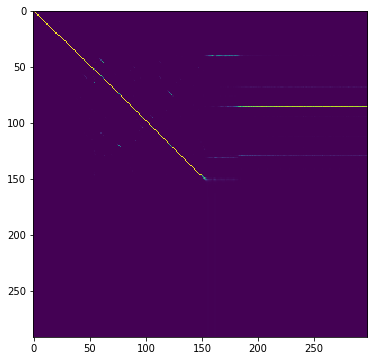

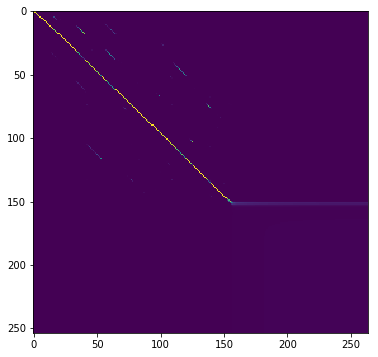

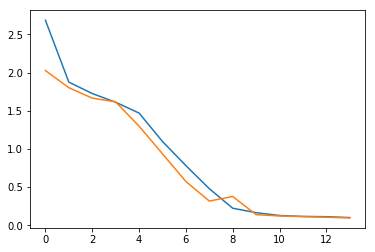

전날 보고서는 이익 추정치를 조금 더 보수저그로 추정하기 위한 거실 뿐 여녜기획싸 시장에 전망을 부정저그로 본 게 전혀 아니라는 취지다.<eos>                                                                                                                                          
전날 보고선ᅳᆫ 이익 추정치를 조금 더 보수적으로 추정하기 위한 것일 분 연예기획사 시장에 전망을 부정적으로 촌 게 전혀 아니라는 취지다.<eos><eos><eos>ᄉᄋᄋᄌᄋᄋᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇᄇ
전날 보고서는 이익 추정치를 조금 더 보수적으로 추정하기 위한 것일 뿐 연예기획사 시장의 전망을 부정적으로 본 게 전혀 아니라는 취지다.<eos>                                                                                                                                             
이날 기준 개정에 따라 이날 이후 확쩡된 판결써에는 판사와 검사뿐 아니라 소송ᄃ

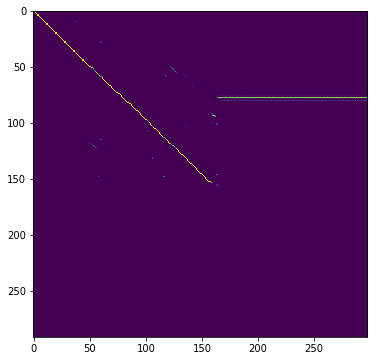

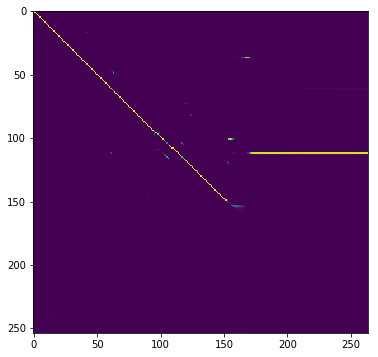

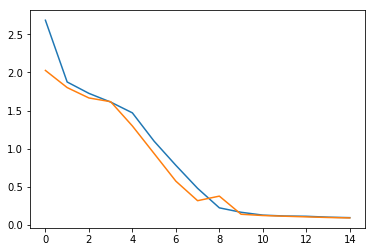

즉 하녹꽈 양오기라는 뇽어는 외래에 건충 냥시기 도입뙨 니후에 서로 다른 건충 냥시글 구분하기 위하여 생겨난 근대에 신조어이다 <eos>                                                                                                                                                 
즉  하ᄂ옥과 양오ᄀ이라는 용어는 외래에 건충 양식으 도입된 이후에 시로 다른 건충 양식을 구분하기 위하여 생견ᅡᆫ 근대에 신조어이다. <eos><eos><eos>ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
즉, 한옥과 양옥이라는 용어는 외래의 건축 양식이 도입된 이후에 서로 다른 건축 양식을 구분하기 위하여 생겨난 근대의 신조어이다. <eos>                                                                                                                                                  
주요 누각 사찰 명소에는 불근 글씨로 해당 건물 믿 명소에 이르미 저켜 이써 외금

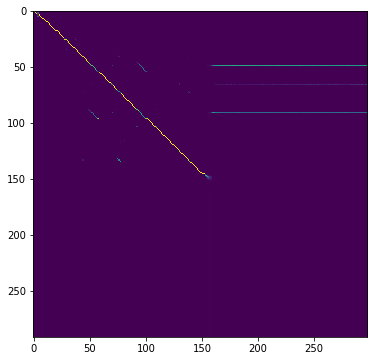

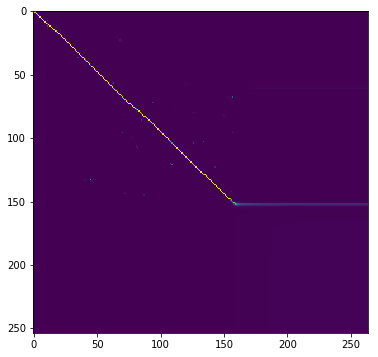

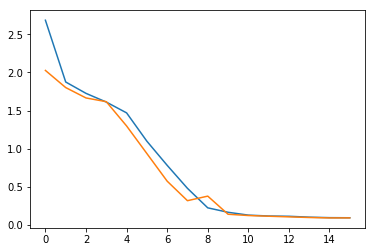

현지 관계자는 모교일 발쌩한 이번 정저니 절령나느로 어려우믈 격꼬 인는 베네수엘라에서 그간 발쌩한 정전 중 최아기라고 발켣따.<eos>                                                                                                                                              
현지 관계자는 목요일 발생한 이번 정전이 절령라ᄂ으로 어려움을 격고 있는 베네수엘라의서 그간 발생한 정전 중 최아ᄀ이라고 발였다.<eos><eos><eos>ᄌᄐᄋᄋᄋᄋᄋᄋᄆᄆᄆᄆᄆᄆᄆᄆᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
현지 관계자는 목요일 발생한 이번 정전이 전력난으로 어려움을 겪고 있는 베네수엘라에서 그간 발생한 정전 중 최악이라고 밝혔다.<eos>                                                                                                                                                
위원회에 회이는 위원장이 피료하다고 인정하는 때에 소지파되 재저귀원 과반수에 출ᄊ

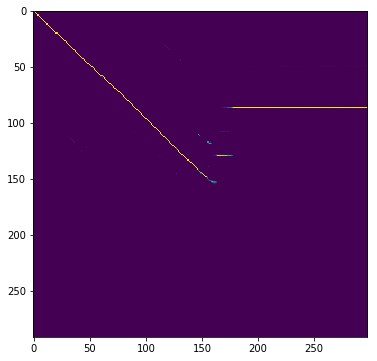

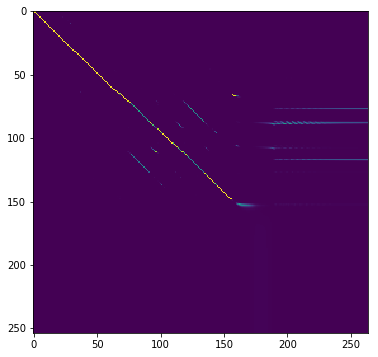

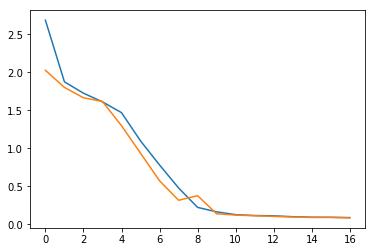

제국쭈이 시대 세계열강에 세력 꾸도는 남쪼그로 팽창을 추진하는 너시아와 이를 쩌지하려는 녕국꽈 미국 등에 대립 구도 소게서 전개되얻따.<eos>                                                                                                                                          
제국주이 시대 세계열강에 세력 구돈ᅳᆫ 남족으로 팽창을 추진하는 여시아와 일ᅳᆯ 저지하려는 영국과 미국 등에 대립 구도 소ᄀ에서 전개되었다.<eos><eos><eos><eos> ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐᄐ
제국주의 시대 세계열강의 세력 구도는 남쪽으로 팽창을 추진하는 러시아와 이를 저지하려는 영국과 미국 등의 대립 구도 속에서 전개되었다.<eos>                                                                                                                                               
프로야구에 지를 노피기 위해선 선수마니 메이저리그를 갈 께 아니라 코치드리 미국꽈

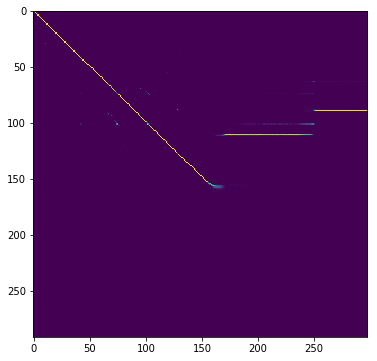

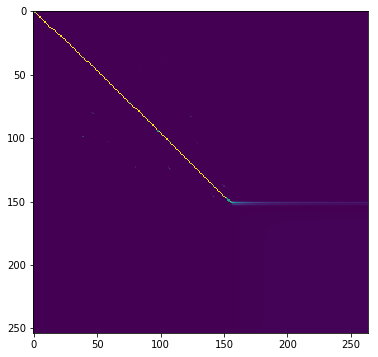

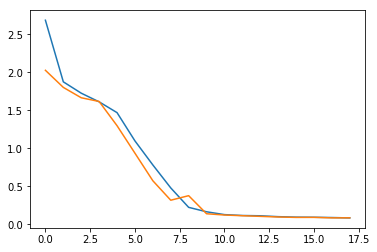

과낙꾸 대책뽄부장은 재난현장에 출똥한 재난괄리채김기과니 쉽께 접끈할 쑤 인느 난전하 뉘치에 통합찌원본부를 설치하여야 한다.<eos>                                                                                                                                            
관악구 ᅡ책본부장은 재난현장의 출동한 재난관리책입기관이 쉽게 접근할 수 있는 안전할 위치에 통합지원본부를 설치하여야 한다.<eos><eos><eos>ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
관악구대책본부장은 재난현장에 출동한 재난관리책임기관이 쉽게 접근할 수 있는 안전한 위치에 통합지원본부를 설치하여야 한다.<eos>                                                                                                                                               
구청장은 이용자에 적끅쩌긴 구정 차며 또는 구정홍보 등을 위하여 피료한 경우 

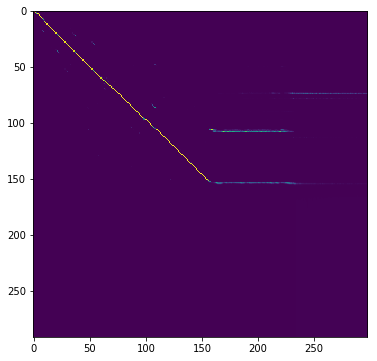

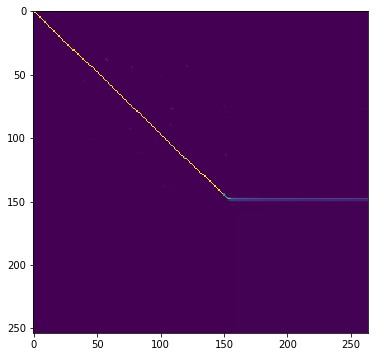

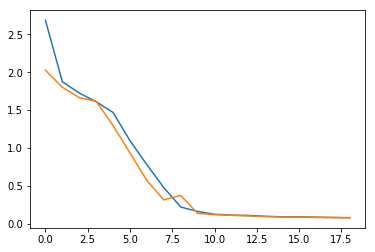

조선 시대 봉수대에 원형 구조는 정화키 알 쑤 업쓰나 봉수대에 시설물과 함께 당나무를 심꺼나 해서 차며자드리 바라는 거슬 비럳따고 한다.<eos>                                                                                                                                           
조선 시대 봉수대에 원형 구존ᅳᆫ 정확히 알 수 없으나 봉수대에 시설물과 함께 당람ᅮ를 심건ᅡ 해서 참여자들이 바라는 것을 비ᄅ었다고 한다.<eos><eos><eos><eos><eos>ᄋᄋᄋᄋᄋᄋᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄒᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
조선 시대 봉수대의 원형 구조는 정확히 알 수 없으나 봉수대의 시설물과 함께 당나무를 심거나 해서 참여자들이 바라는 것을 빌었다고 한다.<eos>                                                                                                                                             
현재는 묘지 조성과 개가느로 형지리 크게 변경되어 지표에 소량에 파펴니 흐터ᄌ

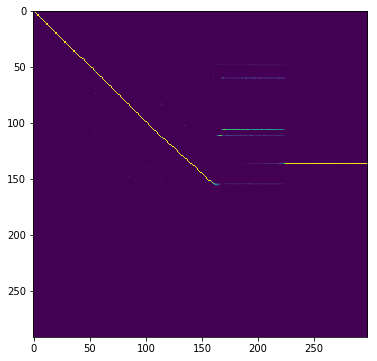

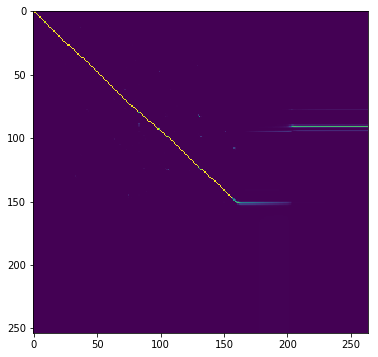

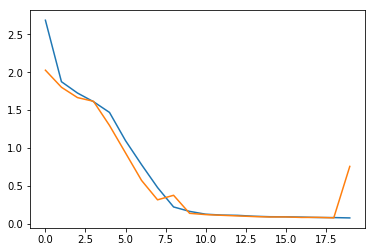

트럼프 행정부는 반정부 시위를 계기로 베네수엘라에 대하 눠뉴 수출 쩨재를 고려하고 읻따고 블룸버그 통시는 소식통을 이뇽해 전핻따.<eos>                                                                                                                                              
트럼프 행정분ᅳᆫ 반정분시위를 계기로 베네수엘라에 대한 원유 수출 제재를 고려하고 있다고 블룸벅ᅳ 통신은 소식통은 인용해 전했다.<eos><eos><eos><eos>  ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄌᄌᄋᄋᄋᄋᄋᄌᄌᄋᄋᄋᄌᄋᄋᄌᄌᄋᄋᄋᄋᄋᄌᄌᄋᄋᄋᄋᄋᄋᄋᄋᄌᄌᄌᄋᄋᄌᄋᄋᄌᄌᄋᄋᄋᄌᄌᄋᄋᄋᄌᄌᄋᄋᄋᄋᄋᄌᄋᄋᄋᄌᄌᄌᄋᄋᄋᄋᄋᄋᄌᄋᄋᄋᄋᄋᄋᄋᄋᄌᄌᄋᄋᄋᄌᄌᄋᄋᄋᄌᄌᄌᄋᄋᄌᄋᄌᄌᄋᄋᄋᄋᄌᄋᄋᄋᄌᄌᄌᄋᄋᄋᄋᄋᄋᄋᄋᄋᄌᄌᄌᄋᄋᄋᄋᄌ
트럼프 행정부는 반정부 시위를 계기로 베네수엘라에 대한 원유 수출 제재를 고려하고 있다고 블룸버그 통신은 소식통을 인용해 전했다.<eos>                                                                                                                                                 
위원회에 청소년뉴해업쏘 믿 안저뉘해업쏘 등 유해환경에 지속쩌긴 감시 믿 ᄀ

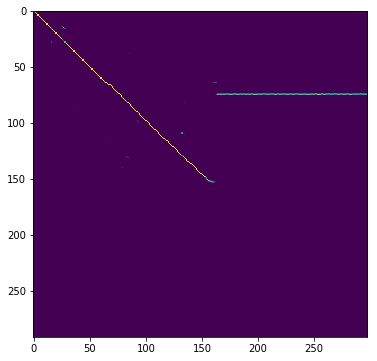

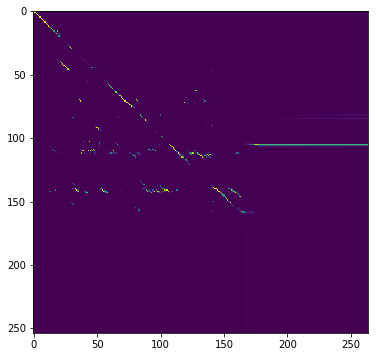

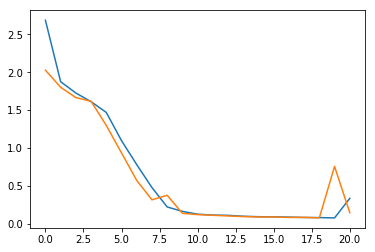

그러나 최근 일본군 위안소를 우녕핻떤 닐본구니네 증언과 공식쩌긴 문서가 속쏙 발견되고 이써 일본 정부에 채김노니 점차 커지고 읻따.<eos>                                                                                                                                       
그러나 최근 일본 ᅮᆫᄋ위안소를 운영했던 닐본 ᅮᆫ인에 증언과 공식적인 문석ᅮ 속속 발견되고 있어 을혼 정부에 책임노ᄂ ᅵ 점차 커지고 있다.<eos><eos>ᄇᄉᄃᄋᄉᄋᄄᄋᄆᄋᄆᄋᄉᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
그러나 최근 일본군 위안소를 운영했던 일본군인의 증언과 공식적인 문서가 속속 발견되고 있어 일본 정부의 책임론이 점차 커지고 있다.<eos>                                                                                                                                       
그러나 한구긴드리 항상 외부 세계와 교류해왇꼬 다양한 시기에 외구기늘 자시네 구성워느ᄅ

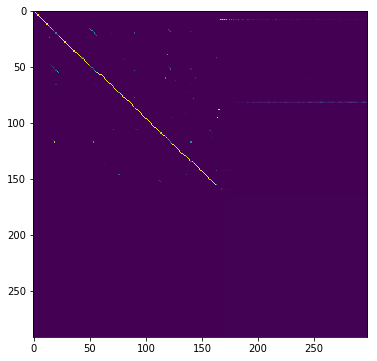

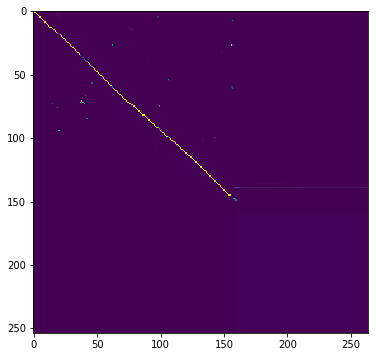

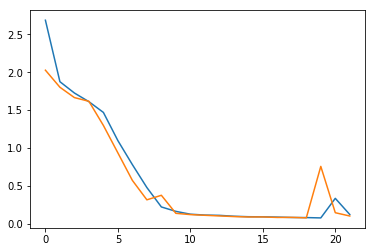

다음 각 호에 어느 하나에 해당하는 차량 중에서 행정지원꽈에 사전검토 믿 부룡처분 승이늘 바든 차량에 한정하여 교체할 쑤 읻따.<eos>                                                                                                                                                 
다음 각 호의 어느 하나에 해당하는 차량ᄋ중에서 행정지원과에 사전검토 및 부ᄅ용첩ᅮᆫ 승인을 받은 차량에 한정자여 교체할 수 있다.<eos><eos>ᄉᄉᄋᄋᄋᄋᄋᄋᄋᄋᄋᄇᄇᄋᄋᄇᄇᄋᄋᄇᄋᄋᄋᄇᄋᄋᄇᄇᄋᄋᄋᄋᄋᄇᄇᄋᄋᄋᄇᄇᄇᄋᄋᄇᄇᄋᄋᄇᄇᄇᄋᄋᄇᄋᄋᄇᄇᄋᄋᄋᄇᄇᄇᄋᄋᄋᄋᄇᄋᄋᄇᄋᄋᄋᄇᄇᄋᄋᄋᄇᄇᄋᄋᄇᄇᄋᄋᄋᄇᄇᄋᄋᄇᄇᄋᄋᄋᄇᄇᄋᄇᄇᄋᄋᄇᄇᄋᄋᄇᄇᄋᄋᄋᄇᄇᄋᄋᄇᄇᄋᄋᄋᄇᄇᄋᄋᄇᄇᄇᄋᄋᄇᄋᄋᄇᄋᄋᄋᄇᄇᄋᄋᄇᄇᄋᄋᄋᄇ
다음 각 호의 어느 하나에 해당하는 차량 중에서 행정지원과의 사전검토 및 불용처분 승인을 받은 차량에 한정하여 교체할 수 있다.<eos>                                                                                                                                                     
우길찌는 일본 국끼인 닐짱기에 태양 무냥 주위에 퍼저 나가는 해싸를 형상화한 거스

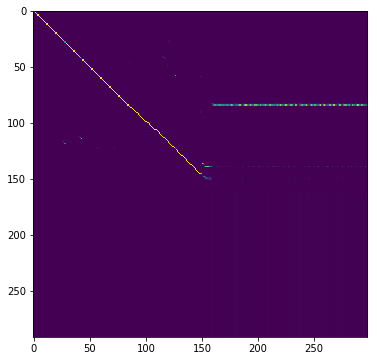

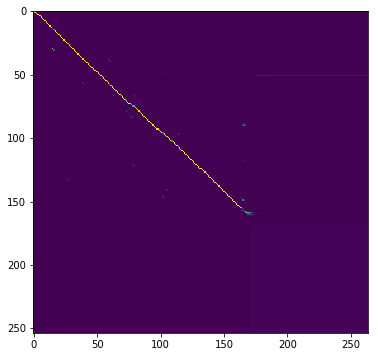

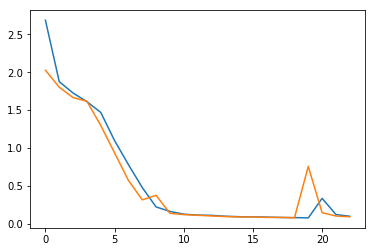

스타벅쓰는 신선하믈 유지하기 위해 충남 논산 경남 산청 등에서 수확뙨 최상급 딸기를 다음날 매장에서 맏뽈 쑤 읻또록 핻따.<eos>                                                                                                                                                
스타벅스는 신선하ᄆ을 유지하기 위해 충람 논산  경람 산청 등에서 수확된 최상급 딸기를 다음날 매장에서 맞볼 사 있도록 했다.<eos><eos><eos>ᄋᄆᄋᄋᄋᄋᄋᄋᄋᄋ    ᄋᄋ  ᄋᄋ     ᄋ          ᄋ  ᄋ    ᄋ ᄋ         ᄋ ᄋ  ᄋ    ᄋ   ᄋ     ᄋ    ᄋ ᄋ  ᄋ ᄋᄋᄋ  ᄋ  ᄋᄋ    ᄋᄋ        ᄋᄋ ᄋ  ᄋᄋᄋ ᄋᄋᄋ ᄋᄋ  ᄋᄋ        ᄋ      
스타벅스는 신선함을 유지하기 위해 충남 논산, 경남 산청 등에서 수확된 최상급 딸기를 다음날 매장에서 맛볼 수 있도록 했다.<eos>                                                                                                                                                     
수사너븐 기르고 잠는 단쑨 어어베서 버서나 보관 가공 유통 수출 연구개발 등 전ᄒ

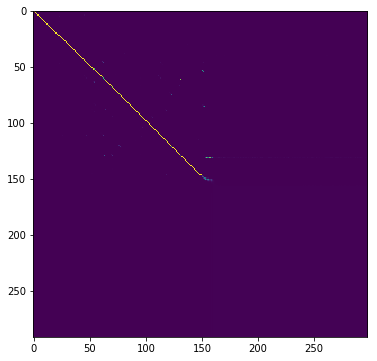

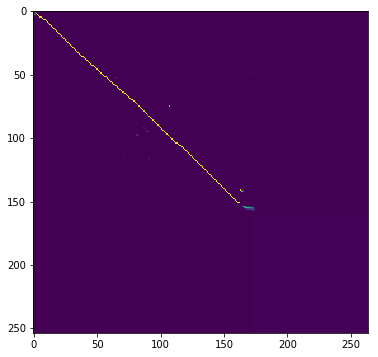

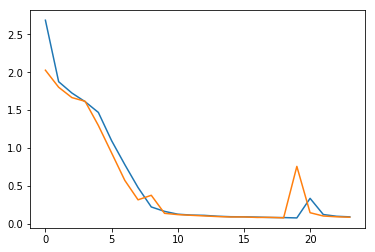

의장은 조사위원회 위원장에게 중간보고를 하게 할 쑤 이쓰며 검토 후 본회이에 의결로 조사위원회이 활똥기가늘 연짱 또는 단추칼 쑤 읻따.<eos>                                                                                                                                         
의장은 조사위원회 위원장에게 중간보기를 하게 할 숙있으며  검토 후 본회의에 의결로 조사위원회의 활동기간을 연장 또는 단축할 수 있다.<eos><eos><eos>ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ                                ᄋ                                    ᄋ  ᄋ           ᄋ ᄋ             ᄋ          ᄋ             
의장은 조사위원회 위원장에게 중간보고를 하게 할 수 있으며, 검토 후 본회의의 의결로 조사위원회의 활동기간을 연장 또는 단축할 수 있다.<eos>                                                                                                                                            
주요 누각 사찰 명소에는 불근 글씨로 해당 건물 믿 명소에 이르미 저켜 이써 외금

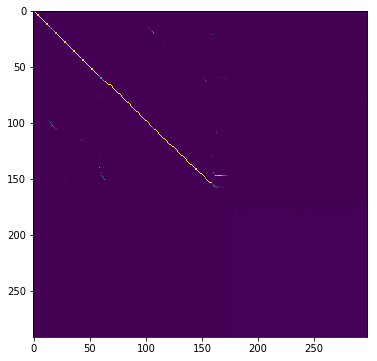

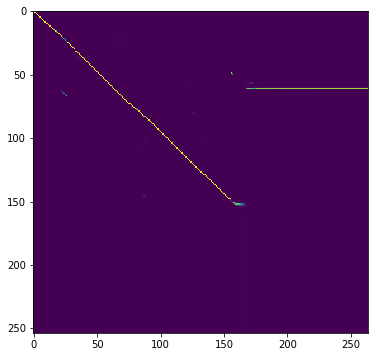

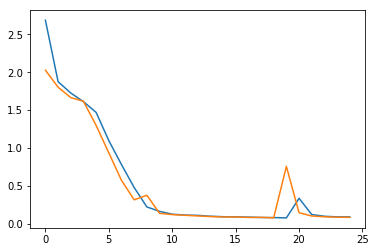

부산 서북뿌에 문화 인프라가 구축뙤지 아는 타세 괄람개기 만치 안치만 꾸준히 기획쩐과 초대저늘 진행하며 쉼 업씨 전시를 이어오고 읻따.<eos>                                                                                                                                         
부산 서북부에 문화 인프라가 구축되지 않은 타ᄉ에 관람개ᄀ이 만지 않이 ᅡᆫ  구준히 기획전과 초대전을 진행하며 쉼 없이 전시를 이어오고 있다.<eos><eos>ᄁᄋᄇᄋ   ᄋᄋᄋ  ᄋᄋ  ᄋᄋᄋᄋᄋ  ᄋ ᄋ ᄋ ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ ᄋᄋᄋᄋᄋᄋᄋ ᄋ  ᄋᄋ ᄋᄋᄋᄋᄋᄋ ᄋ ᄋᄋ ᄋᄋᄋ ᄋᄋ ᄋᄋᄋᄋᄋᄋᄋᄋ ᄋᄋᄋᄋᄋᄋᄋᄋᄋ ᄋᄋᄋᄋᄋᄋ ᄋᄋ ᄋᄋᄋᄋ ᄋᄋᄋᄋᄋ ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ ᄋ ᄋᄋᄋ
부산 서북부의 문화 인프라가 구축되지 않은 탓에 관람객이 많지 않지만, 꾸준히 기획전과 초대전을 진행하며 쉼 없이 전시를 이어오고 있다.<eos>                                                                                                                                           
위원회에 회이는 위원장이 피료하다고 인정하는 때에 소지파되 재저귀원 과반수에 출써그ᄅ

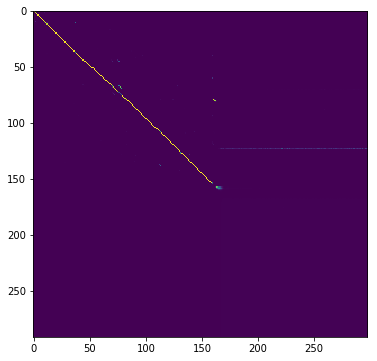

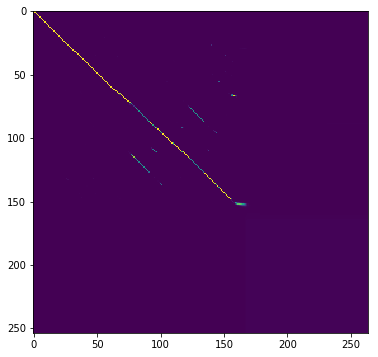

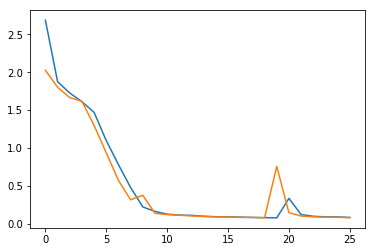

한구근 겨우레는 시베리아 고기아베 영향을 바다 춥꼬 건조하며 여르메는 고온 다스판 북태평양 고기아베 영향으로 무더운 날씨를 보인다.<eos>                                                                                                                                             
한국은 겨울에는 시베리아 고기아ᄇ에 영향을 받아 춥고 건조하며  여름에는 고온 다습한 북태평양 고기아ᄇ에 영향을ᅩ 무더운 날시를 보인다.<eos><eos>ᄇᄇᄀᄀᄇ                                                                                                                                      
한국은 겨울에는 시베리아 고기압의 영향을 받아 춥고 건조하며, 여름에는 고온 다습한 북태평양 고기압의 영향으로 무더운 날씨를 보인다.<eos>                                                                                                                                            
이날 기준 개정에 따라 이날 이후 확쩡된 판결써에는 판사와 검사뿐 아니라 소송대리ᄋ

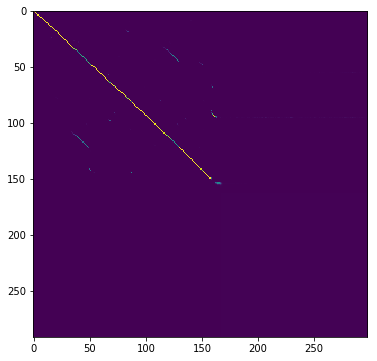

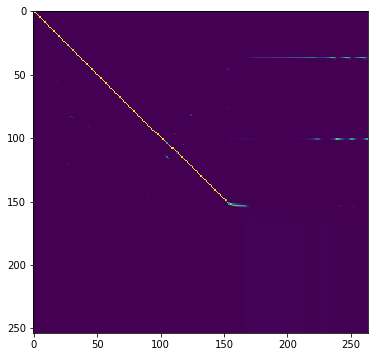

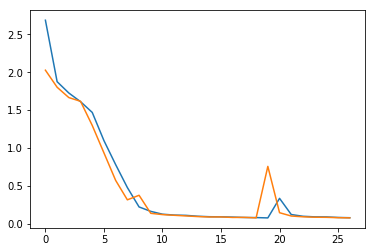

안데스 홍하근 볼리비아 페루 등 남미 안데스 산맥 꼬워네서 사는 히귀종으로 분홍색 털 길고 노란 다리 끄치 거믄 부리가 특찡이다.<eos>                                                                                                                                                  
안데스 홍하ᄀ은 볼리비아  페루 등 남미 안데스 산맥 고원에서 사는 히귀종으로 분홍색 털  길고 노란 다리  그ᄎ이 검은 부리가 특징이다.<eos><eos>ᄐᄋᄋ                                                                                                                                              
안데스 홍학은 볼리비아, 페루 등 남미 안데스 산맥 고원에서 사는 희귀종으로 분홍색 털, 길고 노란 다리, 끝이 검은 부리가 특징이다.<eos>                                                                                                                                                  
소년 소녀드리 둥글게 워늘 그리고 안자 이쓰면 술래는 수거늘 가지고 그 주위를 빙빙 ᄃ

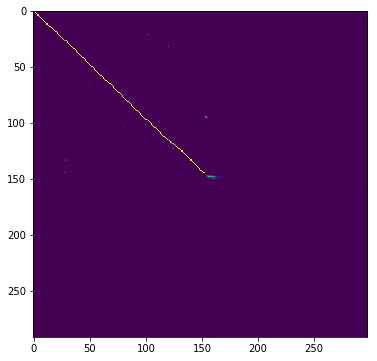

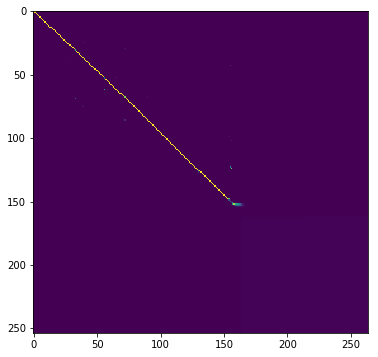

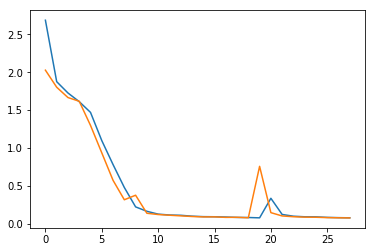

하동에서는 사라미 천수를 다하지 모타고 객찌에서 주거쓸 때 그 홀령이 승천하지 모타고 원귀가 되어 자기 가조기나 친척 등을 괴로핀다고 미덛따.<eos>                                                                                                                                       
하동에서는 사람이 천수를 다하지 못하고 객지에서 주ᄀ었을 때  그 홀령이 승천하지 못하고 권귀가 되어 자기 가족인ᅡ 친척 등을 괴로ᄑ인다고 미ᄃ었다.<eos><eos><eos>ᄋᄋᄋᄋᄋᄄᄄᄋᄋᄄᄋᄋᄋᄋ                           ᄋ                               ᄋ                         ᄋ      ᄋ   ᄋ  ᄋ   ᄋ       ᄋ     
하동에서는 사람이 천수를 다하지 못하고 객지에서 죽었을 때, 그 혼령이 승천하지 못하고 원귀가 되어 자기 가족이나 친척 등을 괴롭힌다고 믿었다.<eos>                                                                                                                                     
시청광장 주벼네 거리에 지하상가에 일부 상저미라도 지상에 이썯떠라면 광장은 훨

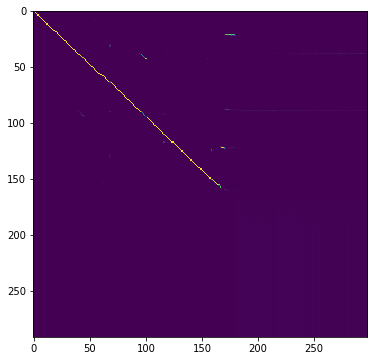

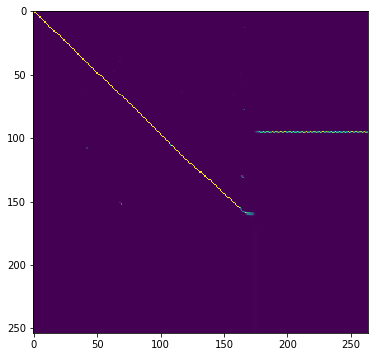

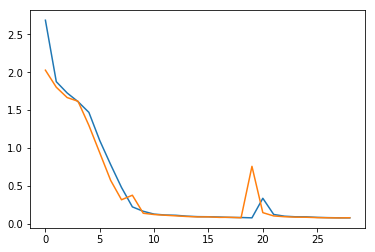

서산 지여근 어촌 농촌 산촌 등 다양한 지역쩍 특썽을 보이고 이쓰며 이러한 생활 모스블 바녕한 노리 문화도 고루 발달하엳따.<eos>                                                                                                                                                  
서산 지역은 어촌  농촌  산촌 등 다양한 지역적 특성을 보이고 있으며  이러한 생활 모습을 보ᄂ영한 노ᄅ이 문화도 고루 발달하였다.<eos><eos><eos>ᄋᄋᄋ      ᄋ                                                                                                                                     
서산 지역은 어촌, 농촌, 산촌 등 다양한 지역적 특성을 보이고 있으며, 이러한 생활 모습을 반영한 놀이 문화도 고루 발달하였다.<eos>                                                                                                                                                 
이날 중국 상무부는 미국싼 철강에 부과하고 인는 반덤핑 관세에 대한 최종 거

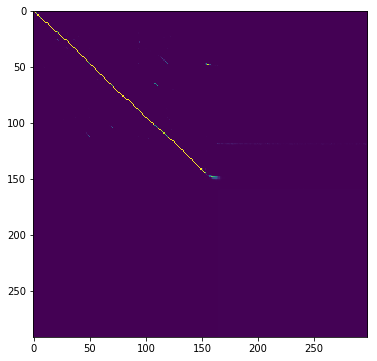

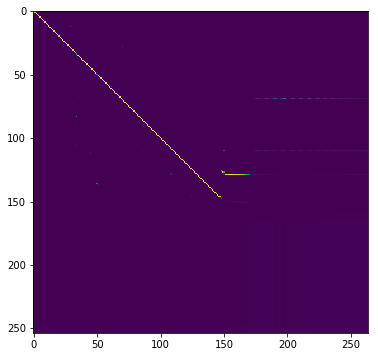

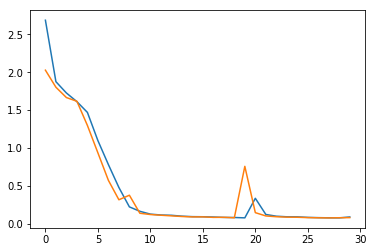

정월 초나흔날 제관 등이 당사네 올라가 제사를 지낸 뒤 마을 주미네 단합꽈 안녕을 위해 소지를 올리는 거스로 제사를 마무리한다.<eos>                                                                                                                                                  
정월 초나흔날 제관 등이 당산의 올라가 제사를 지낸 뒤 마을 주민의 단합과 안녕을 위해 소지를 올리는 것으로 제사를 잠ᅮ리한다.<eos><eos>ᄋᄄᄋ ᄋᄋ ᄋᄋᄋ ᄋᄋ        ᄋ       ᄋ ᄋ      ᄋᄋ      ᄋ         ᄋ     ᄋ ᄋᄋ      ᄋ   ᄋ      ᄋ  ᄋᄋ    ᄋ    ᄋ     ᄋᄋ   ᄋᄋ ᄋ ᄋ  ᄋᄋᄋᄋ   ᄋᄋᄋ ᄋᄋ     ᄋᄋ ᄋ     ᄋ    ᄋ
정월 초나흗날 제관 등이 당산에 올라가 제사를 지낸 뒤 마을 주민의 단합과 안녕을 위해 소지를 올리는 것으로 제사를 마무리한다.<eos>                                                                                                                                                      
현재는 묘지 조성과 개가느로 형지리 크게 변경되어 지표에 소량에 파펴니 흐터저 이쓸 뿐 

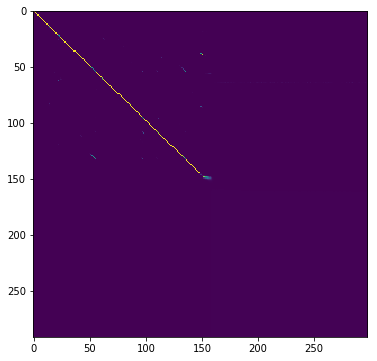

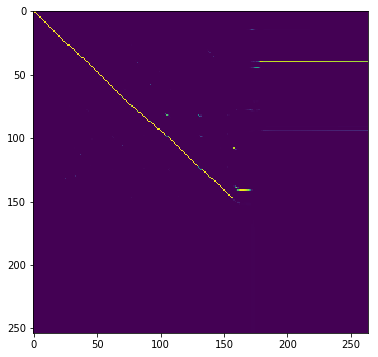

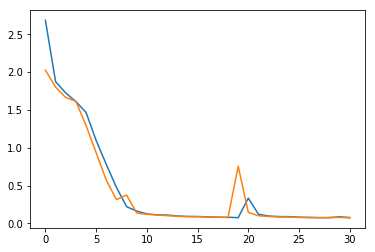

구청장은 예사니 허용하는 버뮈에서 지권 펴네 시설 체력딸련시설 휴양시설 등 공무워네 후생복찌를 위한 시서를 우녕할 쑤 읻따.<eos>                                                                                                                                                  
구청장은 예산이 허용하는 범위에서 지ᄀ원 편에 시설  체력달련시설  휴양시설 등 공무원에 후생복지를 위한 시설을 운영할 수 있다.<eos><eos><eos>  ᄋᄋᄋᄋᄋᄋᄋ                                                                    ᄋ                             ᄋ         ᄋ                        
구청장은 예산이 허용하는 범위에서 직원 편의 시설, 체력단련시설, 휴양시설 등 공무원의 후생복지를 위한 시설을 운영할 수 있다.<eos>                                                                                                                                                
위워는 동장 또는 아동 괄련 단체나 기과니 다음 각 호에 어느 하나에 해당하는 사ᄅ

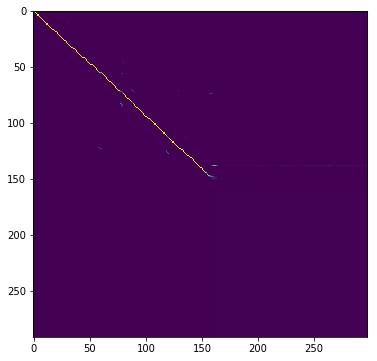

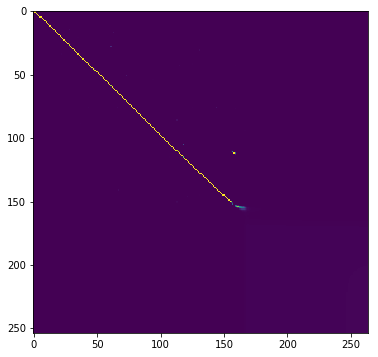

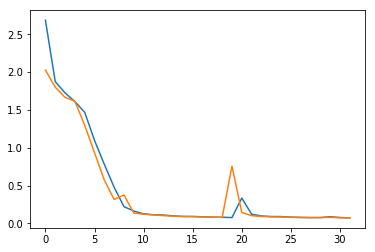

진처는 빨치사니 은신할 쩡도에 큰 산쭐기나 험준한 사니 업써서 정규구니 전투를 버리고 지나간 뒤 후속 전투는 이어지지 아낟따.<eos>                                                                                                                                                  
진천은 빨치산이 은신할 정도의 큰 산줄기나 험준한 산이 없어서 정귝ᅮᆫ이 전투를 버ᄅ이고 지나간 뒤 후속 전툰ᅳᆫ 이어지지 않았다.<eos><eos><eos>ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ                                                                                                                                       
진천은 빨치산이 은신할 정도의 큰 산줄기나 험준한 산이 없어서 정규군이 전투를 벌이고 지나간 뒤 후속 전투는 이어지지 않았다.<eos>                                                                                                                                                   
위워는 동장 또는 아동 괄련 단체나 기과니 다음 각 호에 어느 하나에 해당하는 사ᄅ

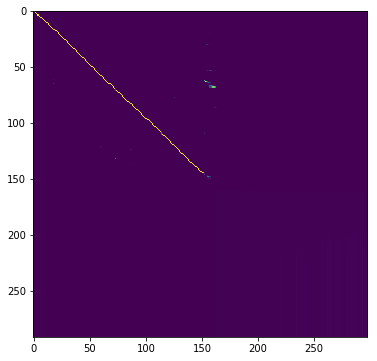

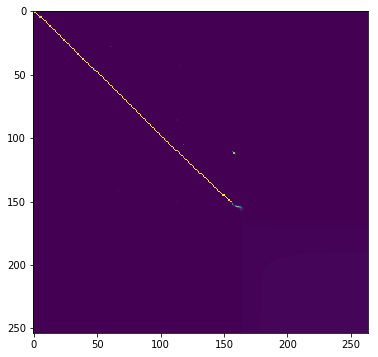

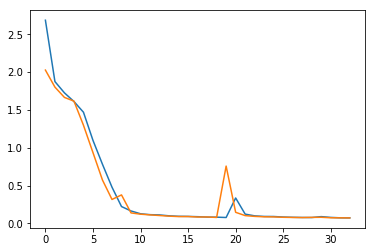

행보칸 방 만들기 사어베 차며할 깨인 단체 기업 등에 자원봉사자나 재능기부자는 구청 복찌지원과 또는 거쩜기과느로 신청하면 된다.<eos>                                                                                                                                              
행복한 방 만들기 사업에 참여할 개인  단체  기업 등에 자원봉사자나 재능기부잔ᅳᆫ 구청 복지지원과 또는 것ᅥᆷ기관으로 신청하면 된다.<eos><eos><eos>ᄒᄒᄋᄒᄋ                                                                              ᄋ                                                         
행복한 방 만들기 사업에 참여할 개인, 단체, 기업 등의 자원봉사자나 재능기부자는 구청 복지지원과 또는 거점기관으로 신청하면 된다.<eos>                                                                                                                                               
이날 기준 개정에 따라 이날 이후 확쩡된 판결써에는 판사와 검사뿐 아니라 소송ᄃ

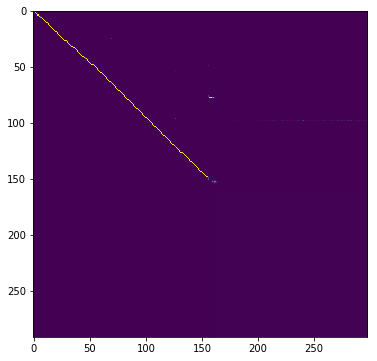

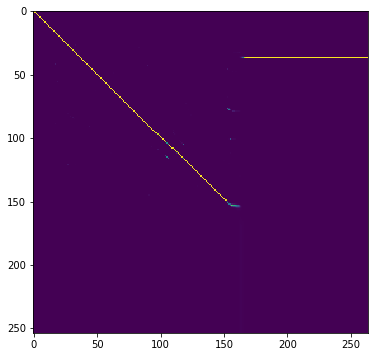

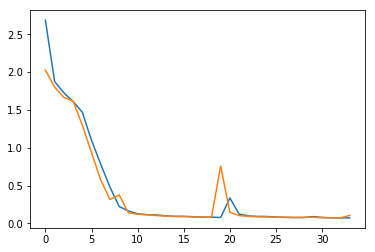

서산 지여근 어촌 농촌 산촌 등 다양한 지역쩍 특썽을 보이고 이쓰며 이러한 생활 모스블 바녕한 노리 문화도 고루 발달하엳따.<eos>                                                                                                                                                  
서산 지역은 어촌  농촌  산촌 등 다양한 지역적 특성을 보이고 있으며, 이러한 생활 모습을 바ᄂ영한 조ᄅ이 문화도 고루 발달하였다.<eos><eos><eos>ᄋᄋᄋ  ᄋᄋᄇᄇᄋᄋᄋ   ᄋᄋᄋᄋᄋᄋ   ᄋ  ᄋᄋᄋᄋ   ᄋ   ᄋᄋ    ᄋᄋ  ᄋᄋᄋᄋ      ᄋ ᄋᄋᄋ       ᄋ  ᄋᄋᄋ  ᄋ  ᄋᄋᄋ     ᄋᄋᄋᄋ   ᄋᄋ ᄋᄋᄋ     ᄋᄋ  ᄋᄋᄋ            ᄋᄋ     ᄋᄋᄋᄋᄋ ᄋ   
서산 지역은 어촌, 농촌, 산촌 등 다양한 지역적 특성을 보이고 있으며, 이러한 생활 모습을 반영한 놀이 문화도 고루 발달하였다.<eos>                                                                                                                                                 
마당에는 욕씰 장똑때 변소 광 등이 위치하엳꼬 대부분 마루와 직쩝 면하엳끼 때

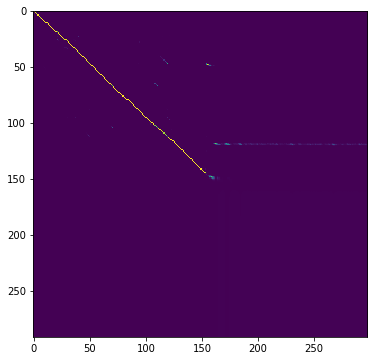

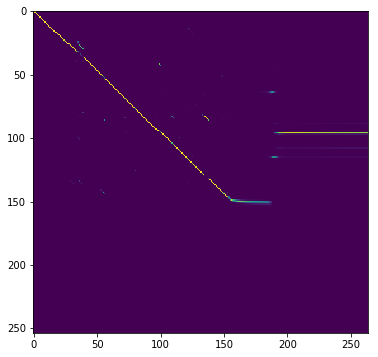

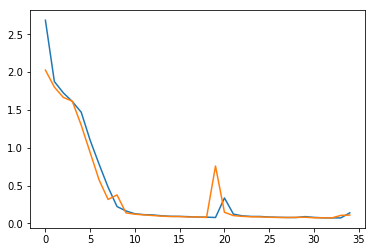

의워느로서 징무와 괄련하여 부정한 니드글 도모하거나 부당한 녕향녀글 행사하지 아니하며 청념하고 검소한 생화를 솔썬수범한다.<eos>                                                                                                                                                  
의원으로서 징무와 관련하여 부정한 시드ᄀ을 도모하거나 부당한 셩향력을 행사하지 않ᅵ하며  청렴하고 검소한 생화ᄅ을 솔선수범한다.<eos><eos>ᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋᄋ
의원으로서 직무와 관련하여 부정한 이득을 도모하거나 부당한 영향력을 행사하지 아니하며, 청렴하고 검소한 생활을 솔선수범한다.<eos>                                                                                                                                                    
이러한 평화는 이순시느로 대표되는 조선 수구네 대한 두려우미 왜인드레게 기피 가긴된 ᄀ

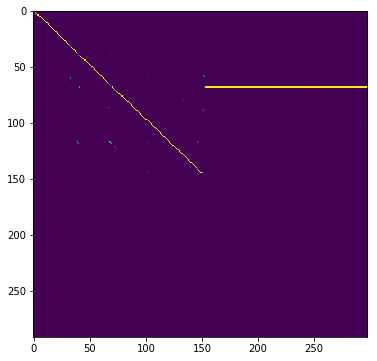

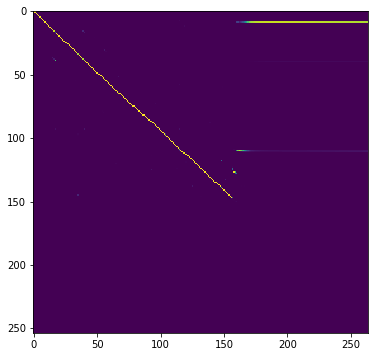

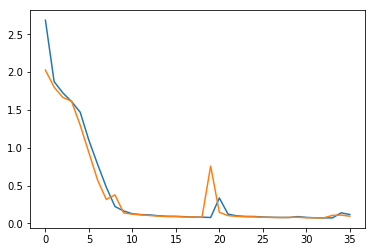

구청장은 동님뉴공자와 국까유공자 믿 그 유가조기 생업 믿 복찌를 위하여 예사네 버뮈에서 다음과 가튼 사항을 우선하여 지원할 쑤 읻따.<eos>                                                                                                                                           
구청장은 동림느옹자이 국가유공자 및 그 유가족이 생업 및 복지를 우하여 예산에 범위에서 다음과 같은 사항을 우선하여 지원할 수 있다.<eos>ᅩᄇᄇᄋᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄋᄄᄄᄄᄋᄄᄄᄄᄄᄋᄄᄄᄄᄄᄄᄄᄄᄋᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄉᄉᄉᄉᄇᄇᄋᄋᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄᄄ
구청장은 독립유공자와 국가유공자 및 그 유가족이 생업 및 복지를 위하여 예산의 범위에서 다음과 같은 사항을 우선하여 지원할 수 있다.<eos>                                                                                                                                              
구청장은 이용자에 적끅쩌긴 구정 차며 또는 구정홍보 등을 위하여 피료한 경우 다음 가

In [0]:
# 'keyword' determines the save keyword
# Change this keyword if you want to start training a new model
keyword = 'eumun-to-eumjul-bidirectional-2'

# List of loss values
loss_history_train = list()
loss_history_eval = list()

try:
    loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword)).tolist()
    loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword)).tolist()
except:
    print("Loading Failed")

EPOCH = 3 * 60 * 4
    
# Load model if model weights already exists
try:
    net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    train_batch_loader.initialize_batch()
    loss_list_train = list()
    
    while train_batch_loader.end_flag == False:
        eumjul_batch, eumun_batch, eumun_loss_mask = train_batch_loader.get_batch()
        pred_tensor, attention_tensor, loss = net.train(eumun_batch.to(device), eumjul_batch.to(device), eumun_loss_mask.to(device))        
        loss_list_train.append(loss)

    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    eval_batch_loader.initialize_batch()
    loss_list_eval = list()
    
    while eval_batch_loader.end_flag == False:
        eumjul_batch_, eumun_batch_, eumun_loss_mask = eval_batch_loader.get_batch()
        pred_tensor_, attention_tensor_, loss = net.evaluate(eumun_batch_.to(device), eumjul_batch_.to(device), eumun_loss_mask.to(device))        
        loss_list_eval.append(loss)

    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))
    
    plt.figure()
    plt.plot(loss_history_train)
    plt.plot(loss_history_eval)
    plt.show()
    
    sentence = tokenizer.num2word(eumun_batch[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    _, pred_token = pred_tensor[0].max(-1)
    sentence = tokenizer.num2word(pred_token.detach())
    print(''.join(sentence))
    
    sentence = tokenizer.num2word(eumjul_batch[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    plt.figure(figsize = (6, 6))
    plt.imshow(attention_tensor[0].detach().cpu().numpy())
    plt.show
    
    sentence = tokenizer.num2word(eumun_batch_[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    _, pred_token = pred_tensor_[0].max(-1)
    sentence = tokenizer.num2word(pred_token.detach())
    print(''.join(sentence))
    
    sentence = tokenizer.num2word(eumjul_batch_[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    plt.figure(figsize = (6, 6))
    plt.imshow(attention_tensor_[0].detach().cpu().numpy())
    plt.show

    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword), loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword), loss_history_eval)
    

    print("-------------------------------------------------------------------------------------------------------")